In [1]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import NRSur7dq2

from scipy import signal
from scipy.special import sph_harm
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import scri

from math import pi

from matplotlib import rc
from spherical_functions import LM_index as lm

#rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [2]:
%%capture
sur = NRSur7dq2.NRSurrogate7dq2('NRSur7dq2.h5')

## Functions for reading in waveforms, and ramp function for tapering, and functions for evaluating surrogate

In [19]:
def ReadExtrapolatedModesPlain(file, mode, order = 2, mass = 68 * const.M_sun, distance = 400000 * const.kpc, dt=1/2048):

    f = h5py.File(file, 'r')
    
    l = mode[0]
    m = mode[1]
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    t = data[:,0]
    re = data[:,1]
    im = data[:,2]
    #re = re * const.G*mass/((const.c)**2*distance)
    #im = im * const.G*mass/((const.c)**2*distance)  
    #t = t*mass*const.G/(const.c**3)
    ## Subtract peak time
    amp = np.sqrt(h_re**2 + h_im**2)
    t_peak = t[np.argmax(amp)]
    t = t - t_peak
    return t, re, im

def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def EvaluateSurrogatePlain(mode, q, chiA, chiB, phase, mass = 68 * const.M_sun, distance = 400000 * const.kpc):

    l = mode[0]
    m = mode[1]
    
    modes = sur(q, chiA, chiB, init_phase=phase)
    sur_re = modes[l, m].real
    sur_im = modes[l, m].imag
    sur_t = sur.t_coorb
    
    ## Adjust with physical units
    #sur_t = sur_t*mass*const.G/(const.c**3)
    #sur_re = sur_re * const.G*mass/((const.c)**2*distance)
    #sur_im = sur_im * const.G*mass/((const.c)**2*distance)
    
    ## Subtract peak time
    sur_amp = np.sqrt(sur_re**2 + sur_im**2)
    sur_t_peak = sur_t[np.argmax(sur_amp)]
    sur_t = sur_t - sur_t_peak
    
    return sur_t, sur_re, sur_im

    

## Plot surrogate results over waveform

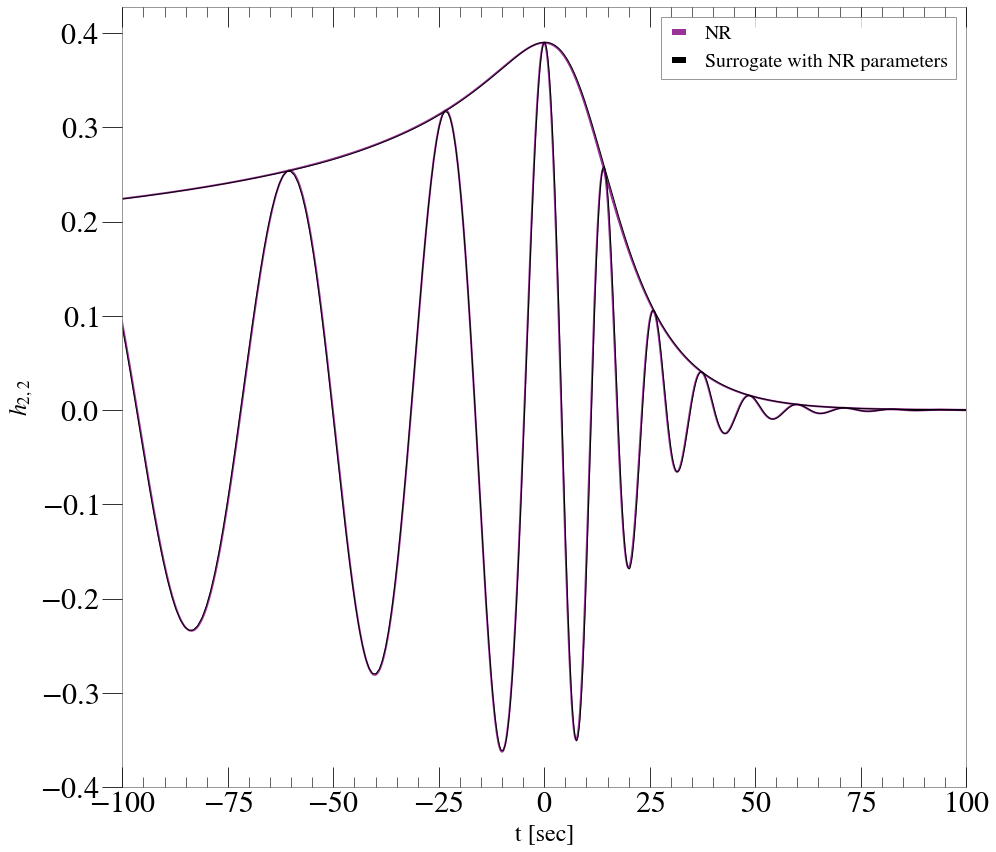

In [21]:
## Mode
mode = [2, 2]

## True physical parameters
q = 1.22125321379
chiA = np.array([0, 0, 0.33]) 
chiB = np.array([0, 0, -0.44])
#mass = 68 * const.M_sun
#distance = 400 * 100 * const.kpc

phase = 0.7

plt.figure(figsize=(14,12))

## Evalute and plot NR waveform
file = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_0p0_Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"
t, h_re, h_im = ReadExtrapolatedModesPlain(file, mode, order = 2, dt=1/2048)


## Apply ramp function and subtract peak time
# t = t - t[0]
# ramp = np.array([Ramp(time, 0.1, 0.3) for time in t.value])
# h_re = h_re * ramp
# h_im = h_im * ramp


plt.plot(t, np.sqrt(h_re**2 + h_im**2), label='NR', lw = 2.0, color='purple', alpha=0.8)
plt.plot(t, h_re, lw = 2.0, color='purple', alpha=0.8)

## Evaluate the surrogate
sur_t, sur_re, sur_im = EvaluateSurrogatePlain(mode, q, chiA, chiB, phase)

plt.plot(sur_t, np.sqrt(sur_re**2 + sur_im**2), label='Surrogate with NR parameters', ls = '-', lw = 1.0, color='black')
plt.plot(sur_t, sur_re, lw = 1.0, color='black')

plt.legend(ncol=1, fontsize=20)
plt.ylabel(r'$h_{2,2}$')
plt.xlabel('t [sec]')
plt.xlim(-100, 100)
#plt.ylim(2.2e-20, 3.2e-20)
plt.grid()
plt.tight_layout()
plt.savefig('SurrogateComparison.pdf')
plt.show()
